### Segmentation 01 (2D)

In [86]:
%run ../utils.py
%run models.py
import os
import os.path as osp
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvutils import visualize
from codex import io as codex_io
from codex import config as codex_config
from skimage import feature
from skimage import filters
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import draw
from skimage import exposure
from scipy import ndimage

plt.gray()
init_session()

exp_name = '20180611_D18_PMBC_500G'
exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'config')
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'nodeconv')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 0
mem_ch = 2
best_z = 21
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(None, None), slice(None, None)]

# exp_name = '7-7-17-multicycle'
# exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle')
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 2
# mem_ch = 1
# best_z = 4
# crop = [slice(0, 512), slice(0, 512)]
# #crop = [slice(None, None), slice(None, None)]

model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.1')
model_path = osp.join(model_dir, 'nuclei_model.h5')

<Figure size 432x288 with 0 Axes>

In [87]:
exp_conf = codex_config.load(exp_conf_dir)

In [88]:
tile = codex_io.read_tile(osp.join(exp_data_dir, 'reg001_X01_Y01.tif'), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

((1, 30, 3, 1008, 1344), dtype('uint8'))

In [89]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [90]:
exp_conf.channel_names

['DAPI', 'DAPIALT', 'MEMBRANE']

In [91]:
# img_nuc = tile[nuc_cyc, best_z, nuc_ch]
# visualize.display_images([filters.rank.median(img_nuc, morphology.square(3))], size=50)

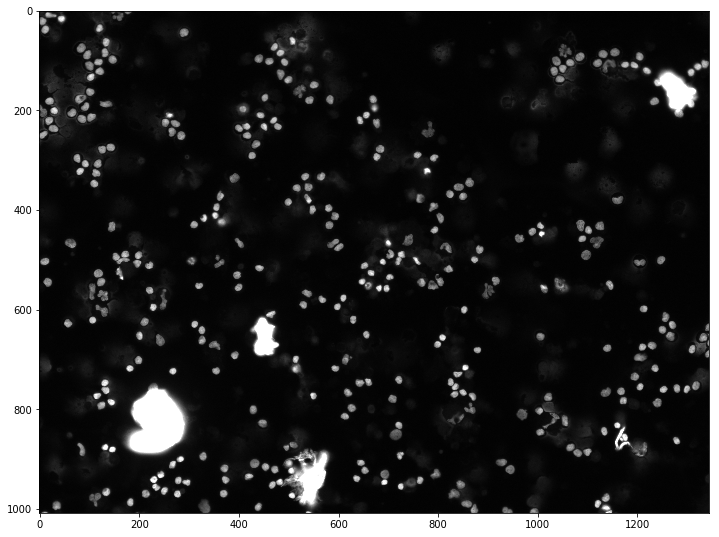

In [92]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
#filters.rank.median(img_nuc, morphology.square(3))
plt.imshow(img_nuc)
plt.gcf().set_size_inches(12, 12)

In [93]:
target_shape = img_nuc.shape + (1,)
model = get_model(3, target_shape, activation='sigmoid', p=[4,5,6,7,8], batch_norm=True, dropout=None)

In [94]:
model.load_weights(model_path)

In [95]:
#model = keras.models.load_model(model_path, compile=False)

In [96]:
img_pred = model.predict(np.expand_dims(np.expand_dims(img_nuc/255., 0), -1))
img_pred.shape

(1, 1008, 1344, 3)

In [97]:
def get_pred_img_overlay(img_pred, chs=[0, 1, 2]):
    return np.stack([
        exposure.rescale_intensity(img_pred[0][..., yi], out_range=np.uint8).astype(np.uint8)
        for yi in chs
    ], -1)

In [98]:
#img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0])[..., 0]
img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0,1,2])
#img_pred_overlay = get_pred_img_overlay(img_pred, chs=[0,2,0])

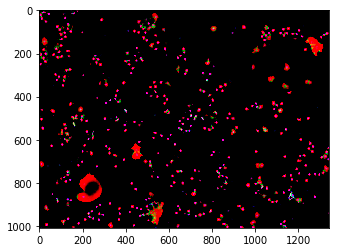

In [99]:
from skimage import img_as_float
plt.imshow(img_as_float(img_pred_overlay))
#plt.imshow(img_as_float(img_nuc))
#plt.gcf().set_size_inches(24, 24)

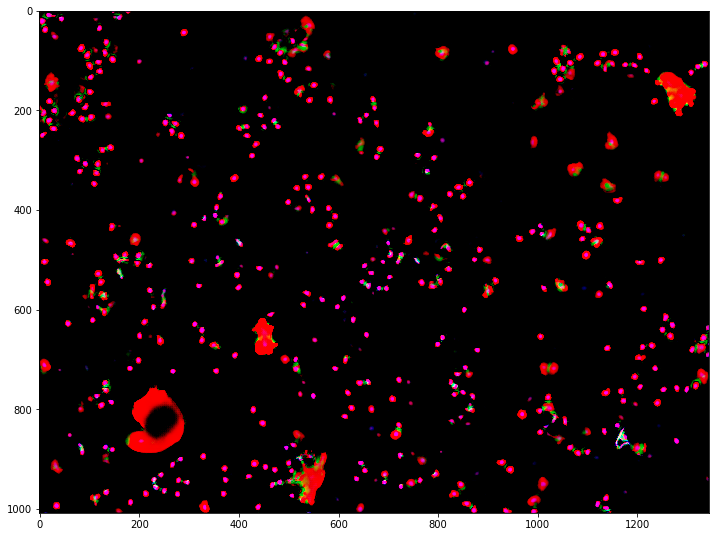

In [100]:
from skimage import color
from skimage import exposure
blend_img = 0.0 * img_as_float(color.gray2rgb(img_nuc)) + \
    1. * img_as_float(color.gray2rgb(img_pred_overlay))
plt.imshow(blend_img)
plt.gcf().set_size_inches(12, 12)

In [101]:
# def prepocess(img, thresh, dilation_factor=1, erosion_factor=1):
#     img = img > thresh
#     img = morphology.dilation(img, selem=morphology.diamond(dilation_factor))
#     img = morphology.erosion(img, selem=morphology.diamond(erosion_factor))
#     img = morphology.remove_small_holes(img, area_threshold=4)
#     img = morphology.remove_small_objects(img, min_size=16)
#     return img

def prepocess(img, thresh, dilation_factor=1, erosion_factor=1):
    img = img > thresh
    img = morphology.remove_small_holes(img, area_threshold=6)
    img = morphology.erosion(img, selem=morphology.diamond(erosion_factor))
    img = morphology.remove_small_objects(img, min_size=8)
    return img

In [102]:
img_bin_nuci = prepocess(img_pred[0, ..., 0], .6)
img_bin_nucb = prepocess(img_pred[0, ..., 1], .6)
img_bin_nucm = prepocess(img_pred[0, ..., 2], .6)

img_bin_nucm = img_bin_nucm & img_bin_nuci & ~img_bin_nucb

In [103]:
# imgt = img_bin_nuci[:250, :250]
# visualize.display_images([imgt, morphology.thin(imgt), morphology.skeletonize(imgt), morphology.erosion(imgt, morphology.disk(4))], cols=3, size=30)

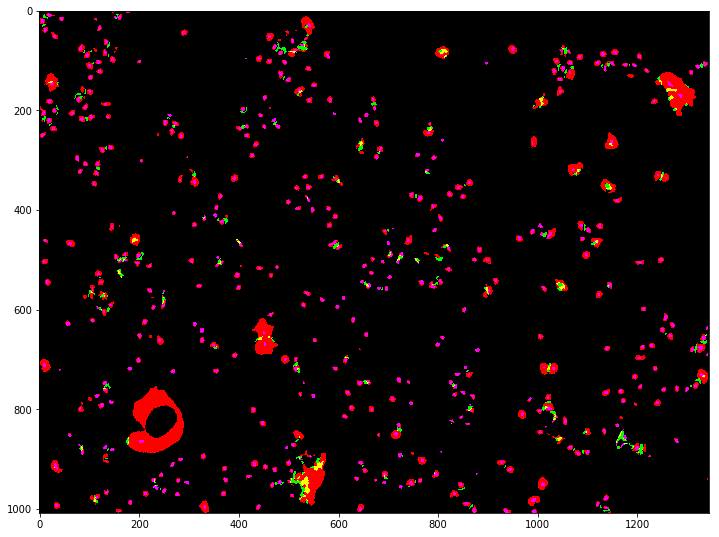

In [104]:
plt.imshow(np.stack([img_bin_nuci, img_bin_nucb, img_bin_nucm], axis=-1).astype(float))
plt.gcf().set_size_inches(12, 12)

In [105]:
img_bin_nucm_label = morphology.label(img_bin_nucm)
img_bin_nuci_basin = ndimage.distance_transform_edt(img_bin_nuci)
img_bin_nucb_basin = ndimage.distance_transform_edt(img_bin_nucb)
img_basin = -img_bin_nuci_basin + img_bin_nucb_basin

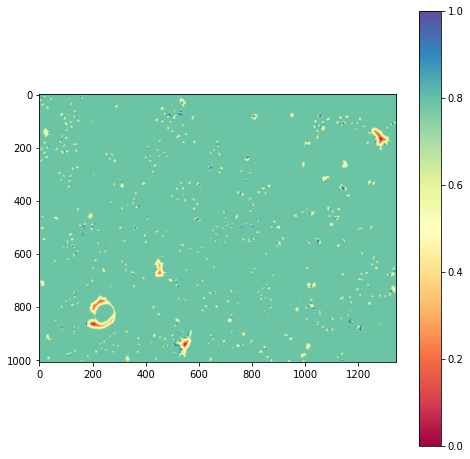

In [106]:
plt.imshow(exposure.rescale_intensity(img_basin, out_range=(0, 1)), cmap='Spectral')
plt.gcf().set_size_inches(8, 8)
plt.colorbar()

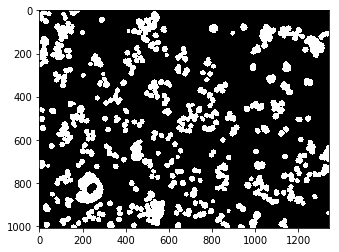

In [107]:
def get_segmentation_mask(img_bin_nuci, img_bin_memb=None, dilation_factor=0):
    if img_bin_memb is None:
        if dilation_factor <= 0:
            return img_bin_nuci
        else:
            return morphology.dilation(img_bin_nuci, selem=morphology.disk(dilation_factor))
    else:
        raise NotImplementedError()
        
seg_mask = get_segmentation_mask(img_bin_nuci, dilation_factor=8)
plt.imshow(seg_mask)

### Run Segmentation

In [108]:
img_seg = segmentation.watershed(img_basin, img_bin_nucm_label, mask=seg_mask)

In [109]:
img_border = segmentation.find_boundaries(img_seg, mode='inner', background=img_seg.min())

In [110]:
img_seg_border = img_seg.copy()
img_seg_border[img_border > 0] = -20
#img_seg_border[img_com > 0] = -30

img_nuc_border = img_nuc.copy()
img_nuc_border[img_bin_nucb > 0] = -50
img_nuc_border[img_bin_nucm > 0] = -20
img_nuc_border[img_border > 0] = -1

# img_mem_border = img_mem.copy()
# img_mem_border[border_img > 0] = -20

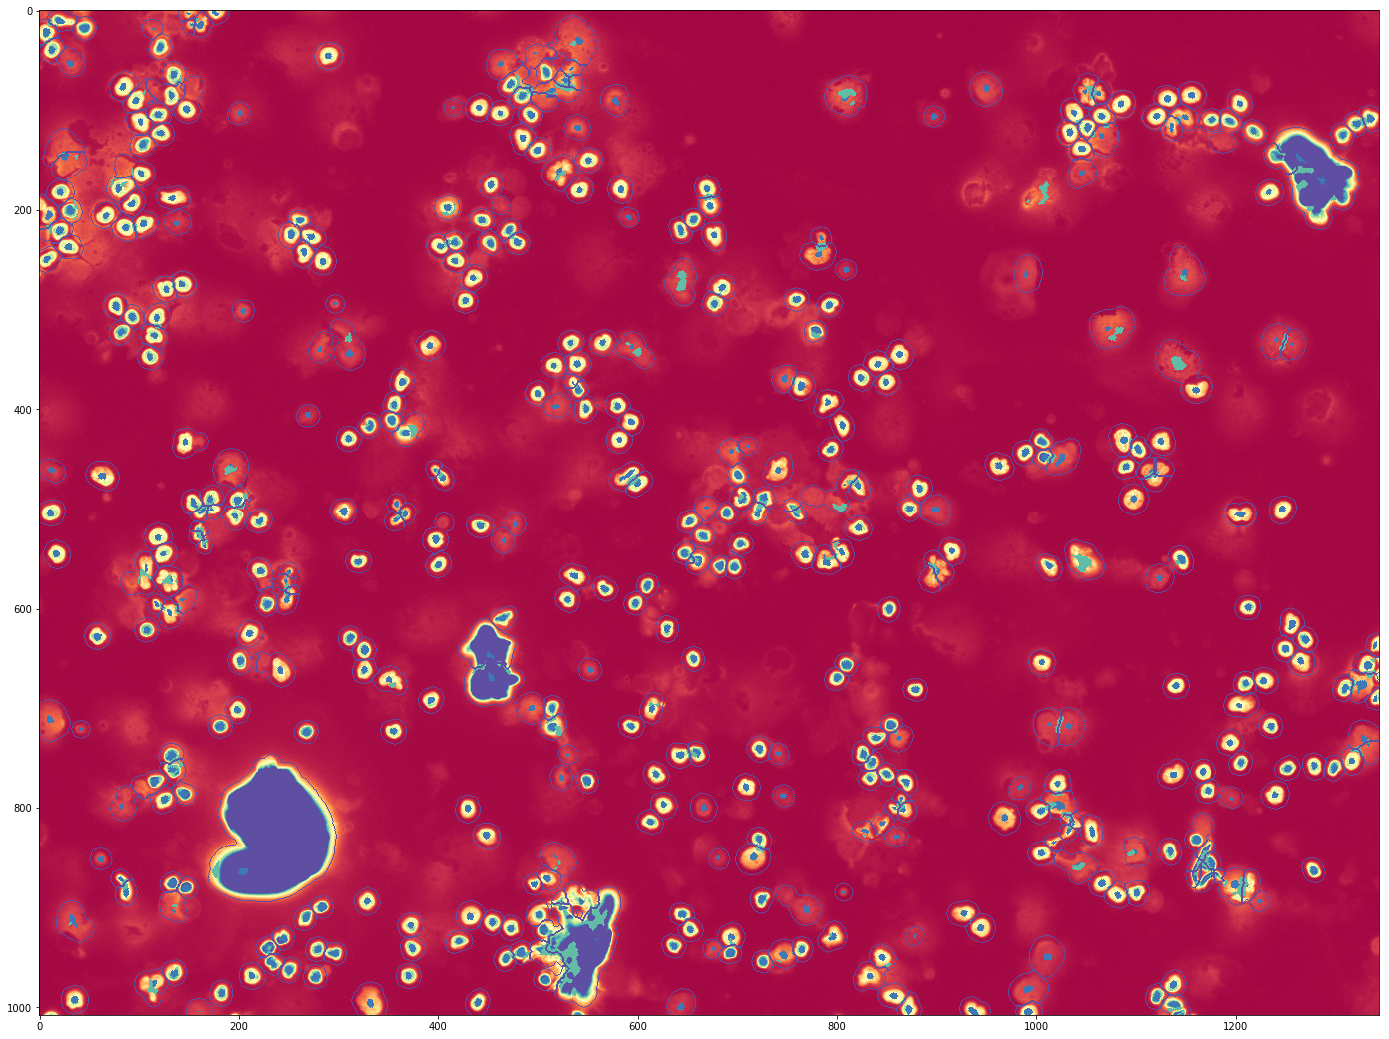

In [111]:
#crop = [slice(0, 256), slice(0, 256)]
#crop = [slice(0, 512), slice(0, 512)]
crop = [slice(0, None), slice(0, None)]
plt.imshow(img_nuc_border[crop], cmap='Spectral')
plt.gcf().set_size_inches(24, 24)

In [26]:
# crop = [slice(0, 500), slice(0, 500)]
# visualize.display_images([
#     img_seg_border[crop], 
#     img_nuc_border[crop],
#     img_mem_border[crop],
#     seg_mask[crop]
# ], size=25, cmap='jet', cols=2)

In [177]:
img_com = np.zeros_like(img_nuc)
props = measure.regionprops(img_bin_nuc_label, intensity_image=img_nuc)
for prop in props:
    r, c = prop.weighted_centroid
    rr, cc = draw.circle(int(r), int(c), radius=2, shape=img_com.shape)
    img_com[rr, cc] = 1
img_com = morphology.label(img_com)